# Growth Curve Analyzer
Created by Gernot Fruhmann, 2019
## Purpose & HowTo
This program imports, cleans, manipulates and analyzes .xlsx-output data created by ThermoFisher Multiskan GO or FC Microplate Photometers.
The data must be provided in a column-sorted format (A01, B01, ... ,G08, H08).
Analysis and output-creation must/can be controlled via a TweakSheet. Adapt it to your needs but do not change the layout.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prefixes and variable overview
- df: pandas dataframe
    - **dfTweakSheet**: content of the GCAnalyzerTweakSheet.xlsx
    - **dfTime**: listed "Times [h]"
    - **dfHalfMaxPoints**: contains y-axis values (OD595nm) of half-maxima of each growth-curve
    - **dfTimePoints**: contains x-axis values (Time [h]) of half-maxima of each growth-curve
- list: python list
    - **listColumnNames**: list of column names/curve labels
- ar: numpy array
- str: string
- dic: dictionary
    - **dicTweakSheet**: the first two columns of dfTweakSheet as a dictionary for access of values even if layout changes (**NEVER change the layout!**)

In [2]:
if os.path.isdir("GCAnalyzerTweakSheet.xlsx") == False:
    print("Please provide the GCAnalyzerTweakSheet.xlsx-file in the current directory.")
else:
    pass

Please provide the GCAnalyzerTweakSheet.xlsx-file in the current directory.


## GCAnalyzerTweakSheet
This retrieves all the information of the TweakSheet and assigns it to values, lists, etc...
Simply change the standard-values in the sheet to adapt the outputs.
**NEVER change the TweakSheet-layout!**

In [3]:
dfTweakSheet = pd.read_excel("GCAnalyzerTweakSheet.xlsx")
dicTweakSheet = dict(zip(dfTweakSheet["Necessary input data"], dfTweakSheet["Standard value"]))
listColumnNames = dfTweakSheet.iloc[0,1:].tolist()
strTitle = dicTweakSheet.get("Title")

In [4]:
dfOri = pd.read_excel("growthCurve.xlsx", skiprows=8, header=0)
dfOri = dfOri.rename({"avg time [min]":"Time [h]"}, axis=1)
dfOri = dfOri.drop(["reading"], axis=1)
dfOri["Time [h]"] = dfOri["Time [h]"] / 60
dfOri["Time [h]"] = dfOri["Time [h]"].astype(int)

# To Delete

In [5]:
#listNames = ["a1","a2","a3","a4","a5","a6","a7","a8"]
#listNames2 = []
#listNames2 = ["df"+columns for columns in listNames]

## Statistics


In [6]:
dfTime = dfOri["Time [h]"]
dfMeans = pd.DataFrame()
dfSTD = pd.DataFrame()
listHalfMaxTimePoints = listHalfMaxIndeces = listMedian = [0]*len(listColumnNames)
arHalfMaximum = np.zeros(8)
arHalfMaxIndeces = np.zeros(8)
a = 1
b = 9
counter = 0
while counter < len(listColumnNames):
    dfMeanCalculation = dfOri.iloc[:,a:b].mean(axis=1)
    listMedian[counter] = dfMeanCalculation.median()
    dfMeans = pd.concat([dfMeans, dfMeanCalculation], axis=1)
    dfMeans.columns = listColumnNames[0:1+counter]
    
    varMinimum = dfMeans[listColumnNames[counter]].min()
    varMaximum = dfMeans[listColumnNames[counter]].max()
    arHalfMaximum[counter] = (varMinimum + (varMaximum - varMinimum) / 2)
    
    dfSTDCalculation = dfOri.iloc[:,a:b].std(axis=1)
    dfSTD = pd.concat([dfSTD, dfSTDCalculation], axis=1)
    dfSTD.columns = listColumnNames[0:1+counter]
    
    arHalfMaxIndeces[counter] = dfMeans.iloc[(dfMeans[listColumnNames[counter]]-arHalfMaximum[counter]).abs().argsort()[:1]].index.item()
    listHalfMaxTimePoints[counter] = dfTime[arHalfMaxIndeces[counter]]
    
    a += len(listColumnNames)
    b += len(listColumnNames)
    counter += 1

## Half-mxima values
Creates a dfHalfMaxPoints containing the half-maxima values for each growth-curve. They are the points of intersection with the y-axis (OD) and the x-axis (Time [h])

In [7]:
dfHalfMaxPoints = pd.DataFrame(arHalfMaximum).T
dfHalfMaxPoints.columns=listColumnNames

dfTimePoints = pd.DataFrame(listHalfMaxTimePoints).T
dfTimePoints.columns=listColumnNames

dfHalfMaxPoints = dfHalfMaxPoints.append(dfTimePoints, ignore_index=True)
dfHalfMaxPoints.index=["OD595nm","Time [h]"]

In [8]:
dfMeans.insert(loc=0, column="Time [h]", value=dfTime)
dfSTD.set_index(dfMeans["Time [h]"], inplace=True)

Data is plotted here. All in one, later split into subplots.

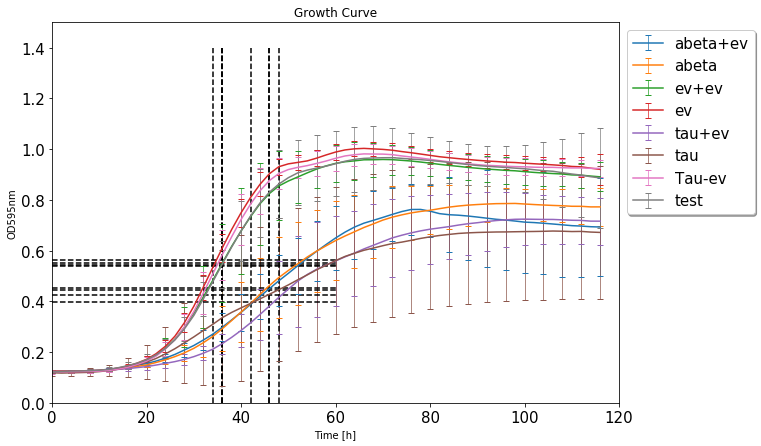

In [10]:
dfMeans.plot(subplots=False, x="Time [h]", yerr=dfSTD, fontsize=15, title=dicTweakSheet.get("Title"), elinewidth=float(dicTweakSheet.get("Error-bar thickness")), errorevery=dicTweakSheet.get("Error-bar steps"), capsize=dicTweakSheet.get("Error-bar cap-size"), figsize=(dicTweakSheet.get("Graph x-size"),dicTweakSheet.get("Graph y-size"))).legend(fontsize=dicTweakSheet.get("Legend fontsize"), framealpha=1, shadow=True, bbox_to_anchor=(1,1))
plt.hlines(arHalfMaximum, xmin=0, xmax=60, linestyle="dashed")
plt.vlines(listHalfMaxTimePoints, ymin=0, ymax=1.4, linestyle="dashed")
plt.ylim(ymin=0, ymax=1.5)
plt.xlim(xmin=0, xmax=dicTweakSheet.get("X-axis maximum"))
plt.ylabel(dicTweakSheet.get("Y-axis label"))
plt.xlabel(dicTweakSheet.get("X-axis label"))
plt.rc("figure", titlesize=30) 
plt.subplots_adjust(right=0.65)
plt.savefig("AllInOne.png")

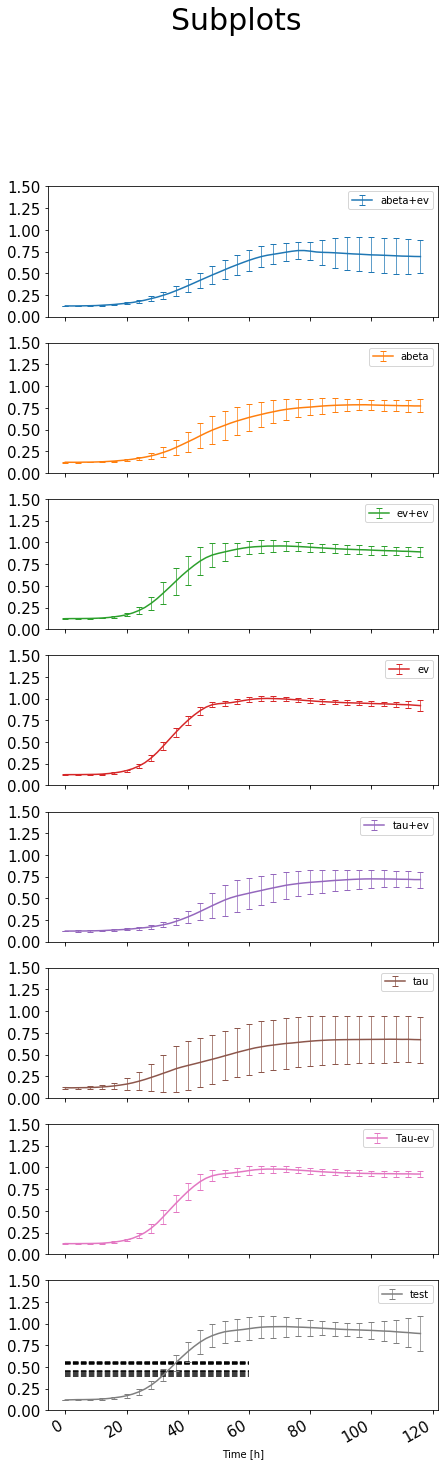

In [11]:
dfMeans.plot(subplots=True, sharey=True, x="Time [h]", yerr=dfSTD, fontsize=15, title="Subplots", elinewidth=0.7, errorevery=2, capsize=3, figsize=(7,25))
plt.ylim(ymin=0, ymax=1.5)
plt.hlines(arHalfMaximum, xmin=0, xmax=60, linestyle="dashed")

plt.savefig("Subplots.png")

## Define styles
Following is a style sheet. Needed?

def highlight(medianValues):
    if medianValues > 0:
        color = "red"
    return "color: %d" % color
dfMeans.style.applymap(highlight, subset=["dfa1"])

## Generate Excel-file

In [12]:
writer = pd.ExcelWriter(dicTweakSheet.get("Title")+".xlsx", engine="xlsxwriter")
dfHalfMaxPoints.to_excel(writer, sheet_name="Mean_values", startrow=0, startcol=0, index=True)
dfMeans.to_excel(writer, sheet_name="Mean_values", startrow=4, startcol=0, index=False)
dfSTD.to_excel(writer, sheet_name="Mean_values", startrow=4, startcol=len(listNames)+2, index=False)
dfOri.to_excel(writer, "Original_data", index=False)
writer.save()

NameError: name 'listNames' is not defined

## ToDo
- retrieve data from TweakSheet
- error-bar thickness from TweakSheet
- add connection points to excel (as df)
- split graphs into singles
- insert output graphs into excel

In [20]:
n = list(range(11, 5))
print(n)

[]
